# Dependencies

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
import pandas as pd
import jellyfish as jf
import numpy as np
from rxnmapper import RXNMapper
import matplotlib.pyplot as plt
rxn_mapper = RXNMapper()
import svgutils.transform as sg
import sys 

# Import Data

In [2]:
datFwds = pd.read_csv('combDatFwds.csv')
datRets = pd.read_csv('combDatRet.csv')
allDatFwds = pd.read_csv('combDatAllFwds.csv')
allDatRets = pd.read_csv('combDatAllRet.csv')
tempDat = pd.read_json('uspto_templ.json')

# Helper Functions

In [3]:
def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    # move atom maps to be annotations:
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def moveAtomMapsToNotes(m):
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))

## Forward Synthesis

In [4]:
list(datFwds.columns)

['reaction number',
 'true rclass',
 'true reaction smiles',
 'true prod',
 'pred reaction smiles',
 'pred prod',
 'conf',
 'projID',
 'predID',
 'T1 Correct',
 'T2 Correct',
 'T3 Correct',
 'T4 Correct',
 'T5 Correct',
 'true_deltaCM',
 'true_deltaSA',
 'fwdpredo_deltaCM',
 'fwdpredo_deltaSA']

In [5]:
list(tempDat.columns)

['retro_template', 'patents', 'common_reagents', 'first_appearance', 'count']

In [6]:
# pull out the "trouble reactions" for forward synthesis 
synthTRsnums = [20, 39, 40, 43, 50]
synthTrs = allDatFwds.loc[allDatFwds['reaction number'].isin(synthTRsnums)]

In [7]:
synthTRpred = list(synthTrs['pred reaction smiles'])
synthTRLit = list(synthTrs['true reaction smiles'])

In [8]:
synthTRPredOuts = rxn_mapper.get_attention_guided_atom_maps(synthTRpred)

#for out in synthTRPredOuts:
 #   display(SVG(draw_chemical_reaction(out['mapped_rxn'],  highlightByReactant=True)))
  #  print(f'Confidence: {out["confidence"]:.2f}')

In [9]:
synthTRLitOuts = rxn_mapper.get_attention_guided_atom_maps(synthTRLit)

#for out in synthTRLitOuts:
 #   display(SVG(draw_chemical_reaction(out['mapped_rxn'],  highlightByReactant=True)))
  #  print(f'Confidence: {out["confidence"]:.2f}')

In [10]:
# in supp info, they posite that the confidence should be higher for correctly mapped reactions, and lower for incorrect maps
# showed that map confidenc was lower for "mistake" reactions (extraction contained some mistake) - maybe refute
# includes templates from Lowe data in supp info, can we do a string similarity/distance to test reactions?

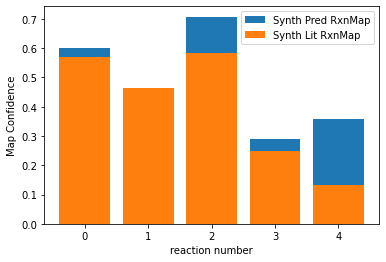

In [11]:
# for our super small set of highlighted wrong reactions, the mapping of wrong reactions is more confient than correct "lit"

sPredMapConfs = [synthTRPredOuts[i]["confidence"] for i in range(len(synthTRPredOuts))]
plt.bar(range(len(synthTRLitOuts)), sPredMapConfs, label='Synth Pred RxnMap')
sLitMapConfs = [synthTRLitOuts[i]["confidence"] for i in range(len(synthTRLitOuts))]
plt.bar(range(len(synthTRLitOuts)), sLitMapConfs, label='Synth Lit RxnMap')
plt.xlabel('reaction number')
plt.ylabel('Map Confidence')
plt.legend()
plt.show()


## Whole Data Set

In [12]:
# take preds where T1 is wrong, take only that have a valid prediction
sT1Wr = [s for s in list(datFwds.loc[datFwds['T1 Correct'] == False]['pred reaction smiles']) if not('"' in s)]
sT1WRmap = rxn_mapper.get_attention_guided_atom_maps(sT1Wr)

sT1WRmapConfs = [sT1WRmap[i]["confidence"] for i in range(len(sT1WRmap))]

In [13]:
# take preds where T1 is correct, take only that have a valid prediction
sT1C = [s for s in list(datFwds.loc[datFwds['T1 Correct'] == True]['pred reaction smiles']) if not('"' in s)]
sT1Cmap = rxn_mapper.get_attention_guided_atom_maps(sT1C)

sT1CmapConfs = [sT1Cmap[i]["confidence"] for i in range(len(sT1Cmap))]

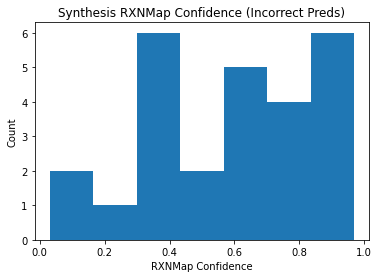

In [14]:
# histogram of confidence occurrences - wrong T1

plt.hist(sT1WRmapConfs, bins=7)
plt.xlabel('RXNMap Confidence')
plt.ylabel('Count')
plt.title('Synthesis RXNMap Confidence (Incorrect Preds)')
plt.show()

In [28]:
with open('t1CMapConfs.txt', 'w') as f:
    for item in sT1CmapConfs:
        f.write("%s\n" % item)

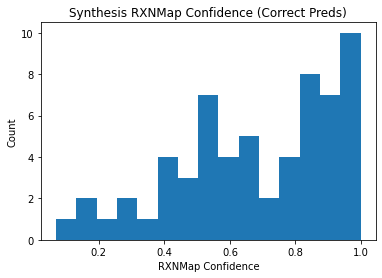

In [15]:
# histogram of confidence occurrences - correct T1

plt.hist(sT1CmapConfs, bins=15)
plt.xlabel('RXNMap Confidence')
plt.ylabel('Count')
plt.title('Synthesis RXNMap Confidence (Correct Preds)')
plt.show()

## Match Patent Templates

In [16]:
# first, can we do a string diff. match b/t mapped templates and mapped trouble reactions?
# then compare smiles vs. common reagents 

# or just start with common reagents --> then get template?

In [17]:
synthTRPredOutsRxns = [i['mapped_rxn'] for i in synthTRPredOuts]

In [18]:
# find the similarities b/t patent template maps and trouble reaction maps
# each row is a test reaction, with cols being the different templates

synthTRLitTemp = [[jf.damerau_levenshtein_distance(i,j) for j in tempDat['retro_template']] for i in synthTRPredOutsRxns]

In [19]:
# shows the most similar index entry in the template data

[np.argmin(i) for i in synthTRLitTemp]

[873, 17208, 11630, 10014, 912]

In [4]:
 # get only the reactants/reagents for trouble reactions
 
  synthTReacs = [j[0] for j in [i.split('>>') for i in synthTrs['true reaction smiles']]]

NameError: name 'synthTrs' is not defined

In [21]:
tempCRs = list(np.concatenate(tempDat['common_reagents']).flat)[0::2]

In [22]:
# crsList is the nested list of common reagents w/o counts after

crsList = []
for temps in tempDat['common_reagents']:
    cr = []
    for crs in temps:
        cr.append(crs[0])
    crsList.append(cr)

In [24]:
[[jf.damerau_levenshtein_distance(i,j) for j in crsList] for i in synthTReacs]

TypeError: str argument expected

In [156]:
# fxn that gives you the template index matched by string similarity of common reagents 

def tCRMatch(strindex):
    trSims = []
    for tempSt in crsList:
        tStrSim = []
        for r in tempSt:
            tStrSim.append(jf.damerau_levenshtein_distance(r,synthTReacs[strindex]))
        trSims.append(tStrSim)
    return trSims.index(min(trSims, key=min))

## Reaction 20

In [23]:
# best template match (rmap) is 873

[np.argmin(i) for i in synthTRLitTemp][0]

873

In [157]:
# best template match (common reagent) is 

tCRMatch(0)

7401

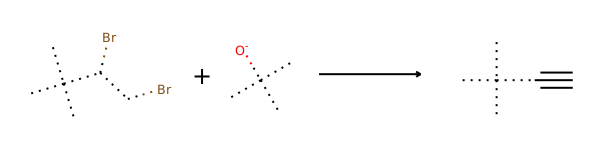

In [24]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(synthTrs['true reaction smiles'].loc[83])

In [5]:
# mapped forward prediction

sr20 = display(SVG(draw_chemical_reaction(synthTRPredOuts[0]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {synthTRPredOuts[0]["confidence"]:.2f}')

NameError: name 'draw_chemical_reaction' is not defined

RDKit ERROR: [07:35:04] non-ring atom 4 marked aromatic
RDKit ERROR: [07:35:04] non-ring atom 1 marked aromatic


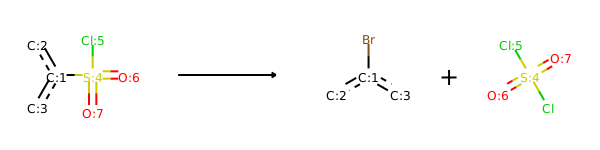

In [30]:
# matched template (rmap)

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[7401])

In [ ]:
# matched template (cr)

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[873])

## Reaction 39

In [27]:
# best template match is 17208

[np.argmin(i) for i in synthTRLitTemp][1]

17208

In [159]:
# best template match (common reagent) is 

tCRMatch(1)

20616

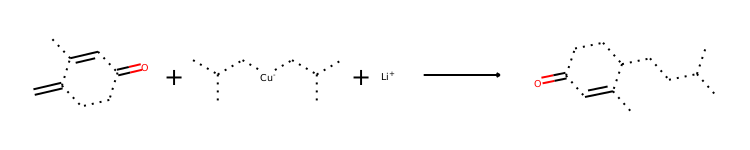

In [28]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(synthTrs['true reaction smiles'].loc[151])

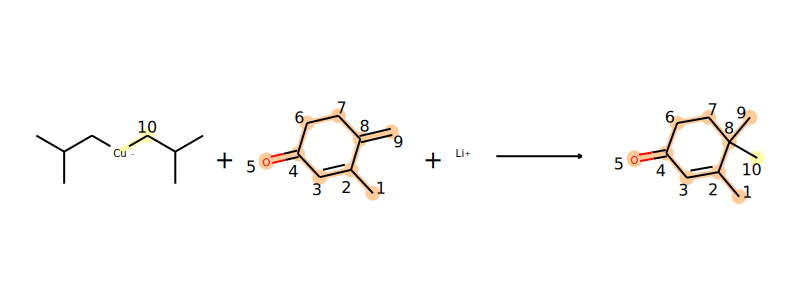

Confidence: 0.39


In [29]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(synthTRPredOuts[1]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {synthTRPredOuts[1]["confidence"]:.2f}')

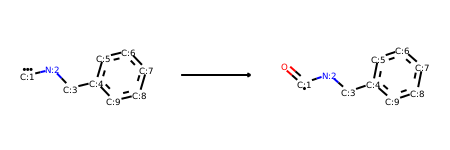

In [30]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[17208])

RDKit ERROR: [10:57:10] non-ring atom 5 marked aromatic
RDKit ERROR: [10:57:10] non-ring atom 1 marked aromatic


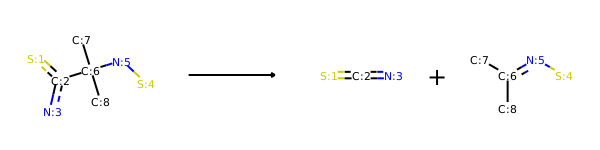

In [160]:
# matched template (rmap)

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[20616])

## Reaction 40

In [31]:
# best template match is 11630

[np.argmin(i) for i in synthTRLitTemp][2]

11630

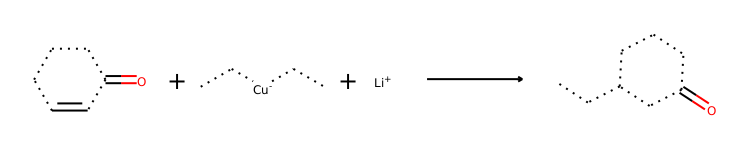

In [32]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(synthTrs['true reaction smiles'].loc[154])

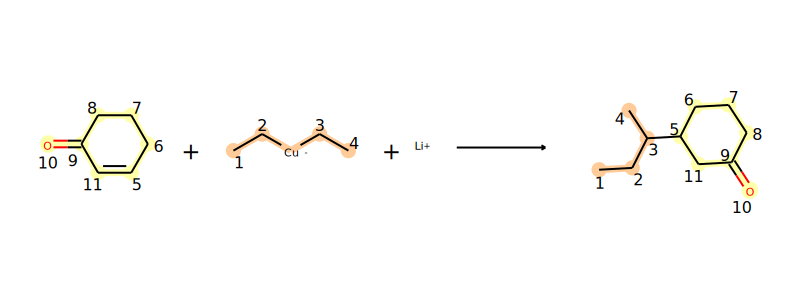

Confidence: 0.71


In [33]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(synthTRPredOuts[2]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {synthTRPredOuts[2]["confidence"]:.2f}')

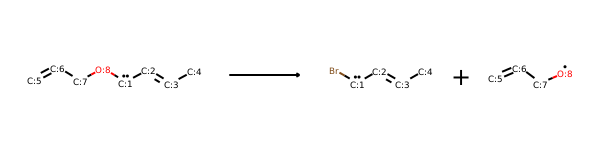

In [34]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[11630])

## Reaction 43

In [35]:
# best template match is 10014

[np.argmin(i) for i in synthTRLitTemp][3]

10014

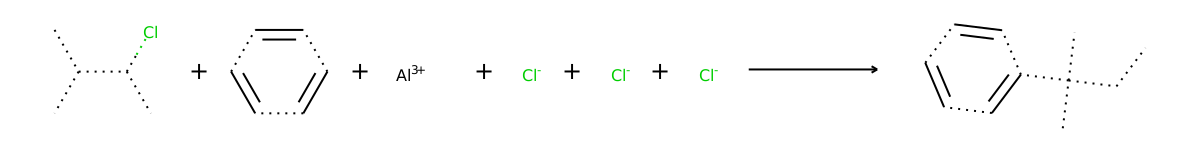

In [36]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(synthTrs['true reaction smiles'].loc[165])

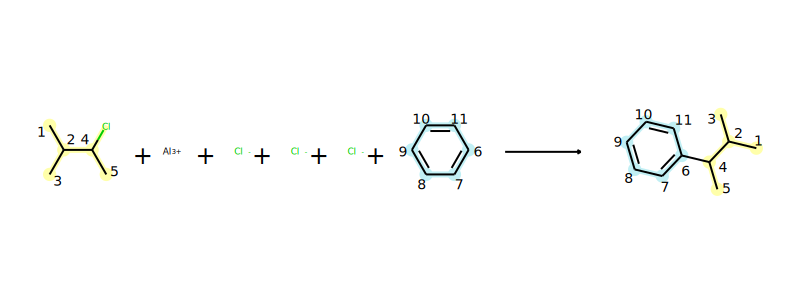

Confidence: 0.29


In [37]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(synthTRPredOuts[3]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {synthTRPredOuts[3]["confidence"]:.2f}')

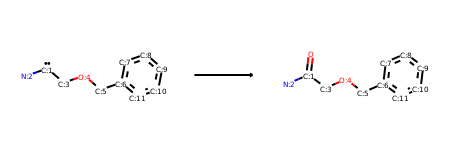

In [38]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[10014])

## Reaction 50

In [39]:
# best template match is 912

[np.argmin(i) for i in synthTRLitTemp][4]

912

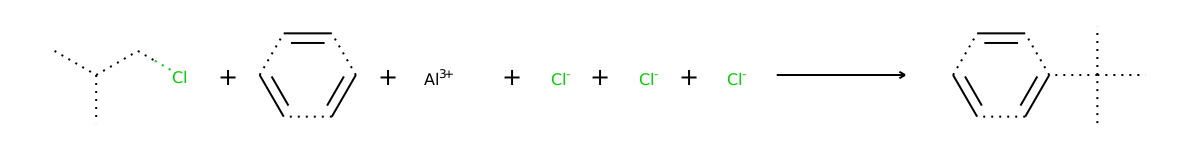

In [40]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(synthTrs['true reaction smiles'].loc[187])

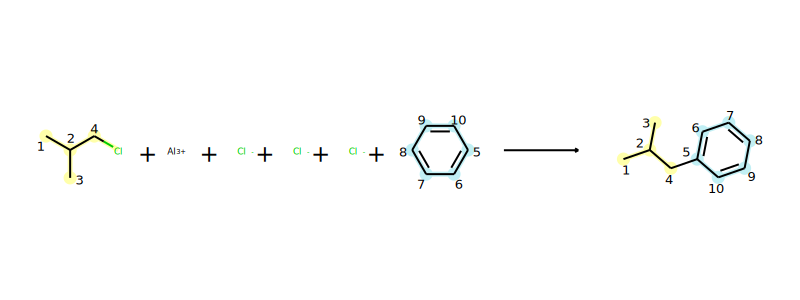

Confidence: 0.36


In [41]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(synthTRPredOuts[4]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {synthTRPredOuts[4]["confidence"]:.2f}')

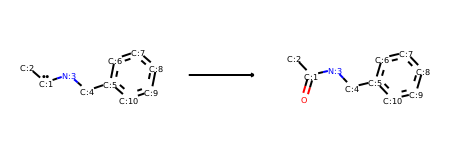

In [42]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[912])

# Retrosynthesis

In [43]:
# pull out the "trouble reactions" for forward synthesis 
retTRsnums = [10, 11, 12, 17, 20, 92]
retTrs = allDatRets.loc[allDatRets['reaction number'].isin(retTRsnums)]

In [44]:
retTRpred = list(retTrs['pred reaction smiles'])
retTRLit = list(retTrs['true reaction smiles'])

In [45]:
retTRPredOuts = rxn_mapper.get_attention_guided_atom_maps(retTRpred)

#for out in retTRPredOuts:
 #   display(SVG(draw_chemical_reaction(out['mapped_rxn'],  highlightByReactant=True)))
  #  print(f'Confidence: {out["confidence"]:.2f}')

In [46]:
retTRLitOuts = rxn_mapper.get_attention_guided_atom_maps(retTRLit)

#for out in retTRLitOuts:
 #   display(SVG(draw_chemical_reaction(out['mapped_rxn'],  highlightByReactant=True)))
  #  print(f'Confidence: {out["confidence"]:.2f}')

## Template Matching

In [47]:
retTRPredOutsRxns = [i['mapped_rxn'] for i in retTRPredOuts]

In [48]:
# each row is a test reaction, with cols being the different templates
retTRLitTemp = [[jf.damerau_levenshtein_distance(i,j) for j in tempDat['retro_template']] for i in retTRPredOutsRxns]

In [49]:
[np.argmin(i) for i in retTRLitTemp]

[17448, 7331, 8647, 1175, 8647, 19527]

In [50]:
retTrs['reaction number']

41     10.0
46     11.0
51     12.0
74     17.0
89     20.0
441    92.0
Name: reaction number, dtype: float64

## Reaction 10

In [51]:
# best template match is 17448

[np.argmin(i) for i in retTRLitTemp][0]

17448

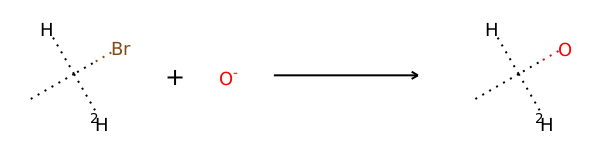

In [52]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(retTrs['true reaction smiles'].loc[41])

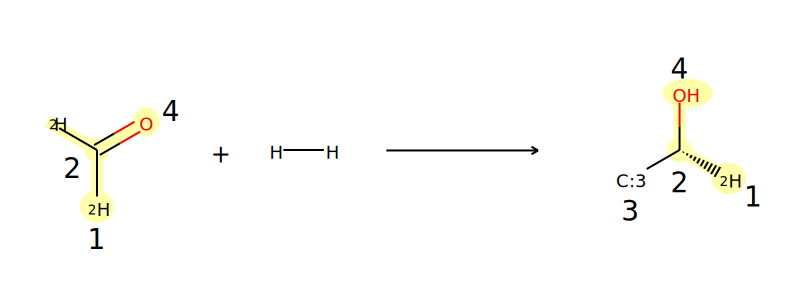

Confidence: 0.84


In [53]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(retTRPredOuts[0]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {retTRPredOuts[0]["confidence"]:.2f}')

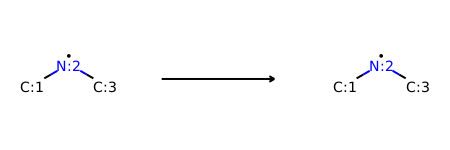

In [54]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[17448])

## Reaction 11

In [55]:
# best template match is 7331

[np.argmin(i) for i in retTRLitTemp][1]

7331

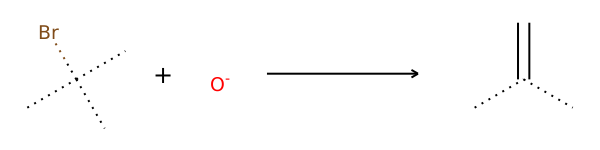

In [56]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(retTrs['true reaction smiles'].loc[46])

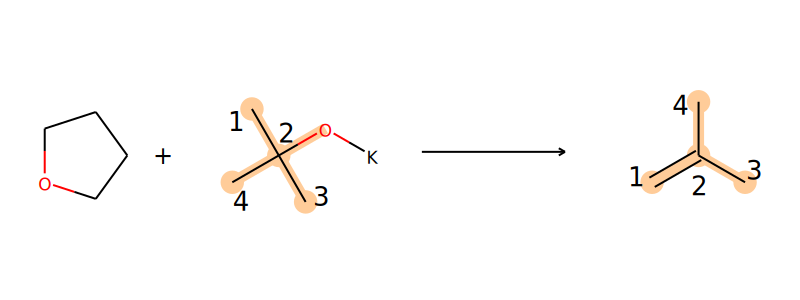

Confidence: 0.45


In [57]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(retTRPredOuts[1]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {retTRPredOuts[1]["confidence"]:.2f}')

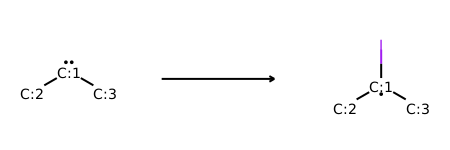

In [58]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[7331])

## Reaction 12

In [59]:
# best template match is 7331

[np.argmin(i) for i in retTRLitTemp][2]

8647

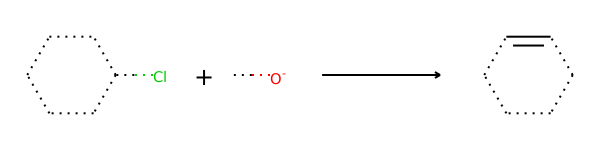

In [60]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(retTrs['true reaction smiles'].loc[51])

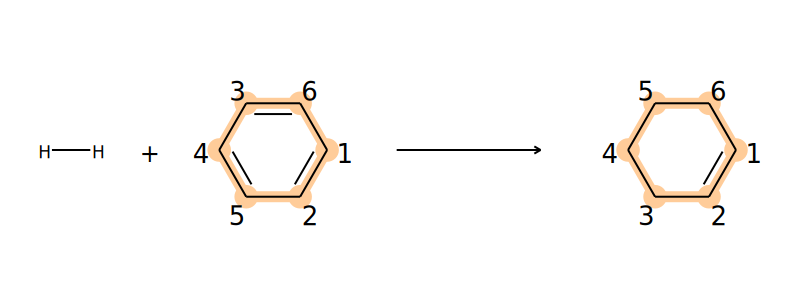

Confidence: 0.25


In [61]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(retTRPredOuts[2]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {retTRPredOuts[2]["confidence"]:.2f}')

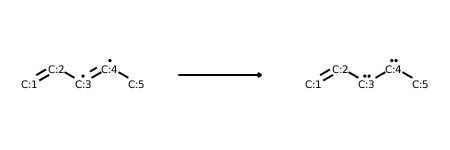

In [62]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[8647])

## Reaction 17

In [63]:
# best template match is 7331

[np.argmin(i) for i in retTRLitTemp][3]

1175

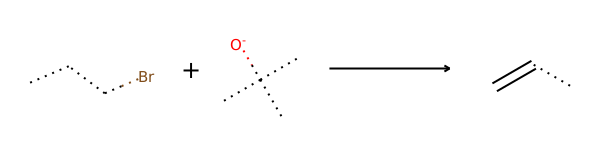

In [64]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(retTrs['true reaction smiles'].loc[74])

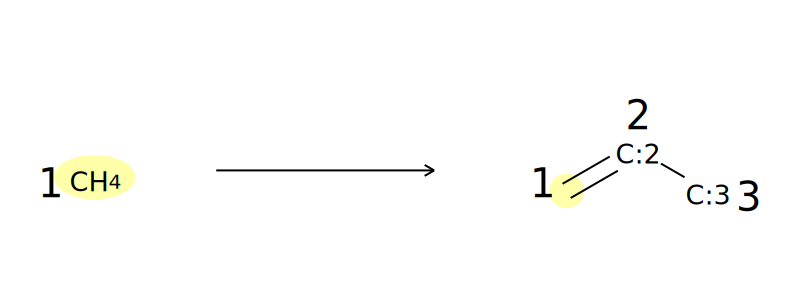

Confidence: 1.00


In [65]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(retTRPredOuts[3]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {retTRPredOuts[3]["confidence"]:.2f}')

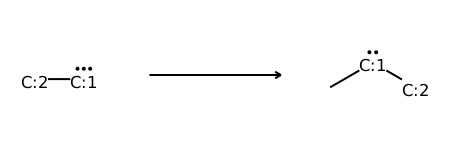

In [66]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[1175])

## Reaction 20

In [67]:
# best template match is 8647

[np.argmin(i) for i in retTRLitTemp][4]

8647

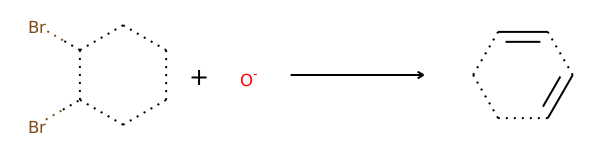

In [68]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(retTrs['true reaction smiles'].loc[89])

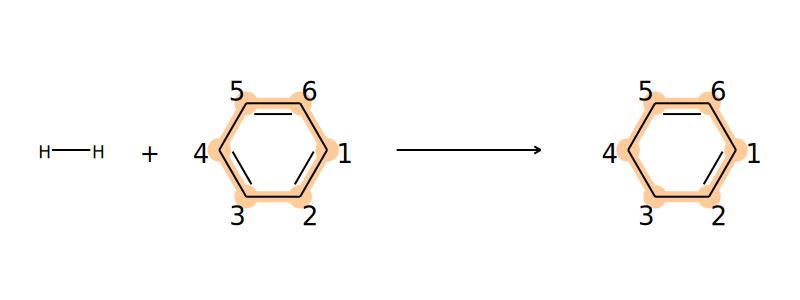

Confidence: 0.22


In [69]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(retTRPredOuts[4]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {retTRPredOuts[4]["confidence"]:.2f}')

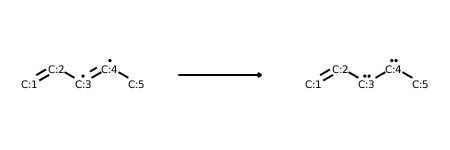

In [70]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[8647])

## Reaction 92

In [71]:
# best template match is 19527

[np.argmin(i) for i in retTRLitTemp][5]

19527

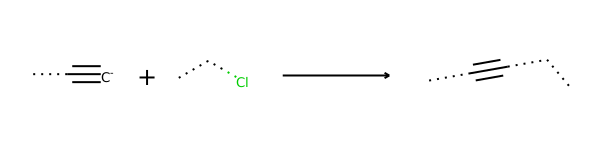

In [72]:
# true forward reaction 

rdChemReactions.ReactionFromSmarts(retTrs['true reaction smiles'].loc[441])

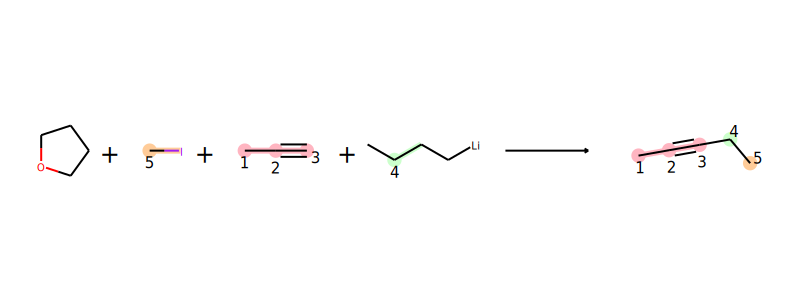

Confidence: 0.20


In [73]:
# mapped forward prediction

display(SVG(draw_chemical_reaction(retTRPredOuts[5]['mapped_rxn'],  highlightByReactant=True)))
print(f'Confidence: {retTRPredOuts[5]["confidence"]:.2f}')

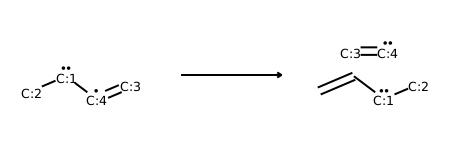

In [74]:
# matched template

rdChemReactions.ReactionFromSmarts(tempDat['retro_template'].iloc[19527])